In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
driver_ana = PySCFDriver(
    atom="H 0 0 0; Be 0 0 1.333; H 0 0 2.666",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

In [3]:
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
problem_ana = ElectronicStructureProblem(
        driver_ana,
        [FreezeCoreTransformer(freeze_core=True)])#,
                               #remove_orbitals=[-3,-2])])

In [4]:
problem_ana = driver_ana.run()

In [5]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, QubitConverter

solver = GroundStateEigensolver(
    QubitConverter(ParityMapper()),
    NumPyMinimumEigensolverFactory(),
)

In [6]:
result = solver.solve(problem_ana)
ana_gs = result.total_energies[0]
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.969402937823
  - computed part:      -18.969402937823
~ Nuclear repulsion energy (Hartree): 3.374348306692
> Total ground state energy (Hartree): -15.595054631131
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  15.11402954]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  15.11402954]
    - computed part:      [0.0  0.0  15.11402954]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  -0.00000001]  Total: 0.00000001
 


In [7]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

# Define Molecule
molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["H", [0.0, 0.0, 0.0]],
        ["Be", [1.33, 0.0, 0.0]],
        ["H", [2.66, 0.0, 0.0]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF)

In [8]:
# Define Problem, Use freeze core approximation, remove orbitals.
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

In [9]:
problem = ElectronicStructureProblem(
    driver,
    [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[2,3])])

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

In [10]:
print(num_spin_orbitals)
print(num_particles)

8
(1, 1)


In [11]:
from qiskit.opflow import TwoQubitReduction
mapper = ParityMapper()#JordanWignerMapper()
converter = QubitConverter(mapper, two_qubit_reduction=True)
hamiltonian = second_q_ops['ElectronicEnergy']
qubit_op = converter.convert(hamiltonian)
reducer = TwoQubitReduction(num_particles)
qubit_op = reducer.convert(qubit_op)
num_particles = num_particles
num_spin_orbitals = num_spin_orbitals -2

In [12]:
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

var = HartreeFock(num_spin_orbitals//2, num_particles, converter)
var.append( UCCSD(num_spin_orbitals//2, num_particles, converter), [i for i in range(num_spin_orbitals)])

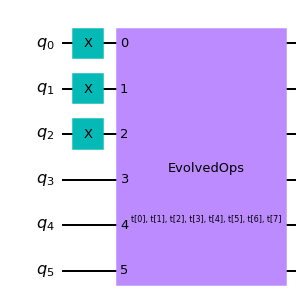

In [13]:
var.draw()

In [31]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
backend = provider.get_backend('ibmq_jakarta')
backend_sim = AerSimulator.from_backend(backend)
noise_model = NoiseModel.from_backend(backend)

In [16]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [17]:
q_layout = [0,1,2,3,5,6]
#ansatz_opt = transpile(var, backend=Aer.get_backend('aer_simulator'), initial_layout=q_layout)
ansatz_opt = transpile(var, backend=backend_sim, initial_layout=q_layout, optimization_level =3)

In [18]:
from qiskit.primitives import Estimator
import time

In [19]:
exp_qubit_op = []

for i in range(len(qubit_op)):
    aux = qubit_op[i].primitive.to_list()
    #print(aux[0][0])
    #print(aux[0][1])
    aux1 = aux[0][0][:3]+'I'+aux[0][0][3:]
    #print(aux1)
    
    exp_qubit_op.append((aux1, aux[0][1]))
    
from qiskit.opflow.primitive_ops import PauliSumOp

auxP = PauliSumOp.from_list(exp_qubit_op)
    

In [21]:
from qiskit.algorithms.optimizers import SPSA, COBYLA

#optimizer = SPSA(maxiter=150)
optimizer = COBYLA(maxiter=100)

In [22]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [auxP])
# Setup VQE algorithm

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time.time()
res_sim = custom_vqe.compute_minimum_eigenvalue(auxP)
end = time.time()

print(res_sim)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -1.3139851053183502,
    'optimal_circuit': None,
    'optimal_parameters': array([ 3.14143459e+00,  8.68185282e-05,  1.57068777e+00, -2.08145470e-01,
       -8.82191053e-01,  1.09014853e+00,  9.58739576e-01, -9.27454562e-04]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 30.27


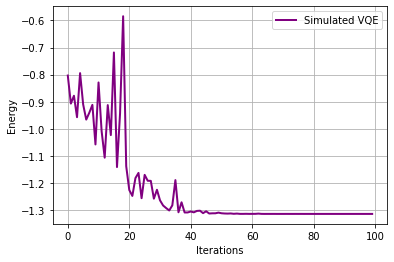

In [23]:
import matplotlib.pyplot as plt
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=ana_gs, color="tab:red", ls="--", lw=2, label="Target: " + str(ana_gs))
plt.legend()
plt.grid()
plt.show()

In [24]:
cmp_gs = problem.interpret(res_sim).total_energies[0].real
print(problem.interpret(res_sim))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.942057982511
  - computed part:      -1.313985105318
  - FreezeCoreTransformer extracted energy part: -17.628072877192
~ Nuclear repulsion energy (Hartree): 3.381959618662
> Total ground state energy (Hartree): -15.560098363849
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [15.08001447  0.0  0.0]
 


In [25]:
print(cmp_gs)
print(ana_gs)
print((ana_gs-cmp_gs)/ana_gs*100)

-15.560098363849027
-15.59505463113102
0.22414969430253295


In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator as RuntimeEstimator, Options
QiskitRuntimeService.save_account(channel="ibm_quantum", token='7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1' ,overwrite=True)
optimizer = COBYLA(maxiter=100)

In [36]:
service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService()
# print available backend and select one
print('Backends:', service.backends())
print('Simulators:', service.backends(Simulator=True))

# Select a simulator backend
#backend_sim = 'ibmq_jakarta'
#backend = service.get_backend('ibmq_jakarta')
#print(provider.backends())
#print(backend)

Backends: [<IBMBackend('ibmq_guadalupe')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibmq_belem')>, <IBMBackend('ibmq_quito')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_oslo')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>]
Simulators: []


In [37]:
print('Simulators:', service.backends(simulator=True))

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [28]:
# Define a simple callback function
intermediate_info_run = []
def callback_run(value):
        intermediate_info_run.append(value)

In [29]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [49]:
provider = IBMQ.get_provider(hub='qhack-event', group='main', project='level-1')
provider.backends()
backend = service.get_backend('ibmq_jakarta')

In [50]:
print(backend)

<IBMBackend('ibmq_jakarta')>


In [51]:
ansatz_opt = transpile(var, backend=backend, initial_layout=q_layout, optimization_level =3)

In [52]:
options = Options()
options.execution.shots = 1024
options.optimization_level = 3
options.resilience_level = 2

In [53]:
start = time.time()
with Session(service=service, backend=backend) as session:
    #  Prepare primitive
    rt_estimator = RetryEstimator(session=session, options=options)# RuntimeEstimator(session=session, options=options)
     # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_run)
     # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(auxP)
end = time.time()
print(f'execution time (s): {end - start:.2f}')

execution time (s): 32547.62


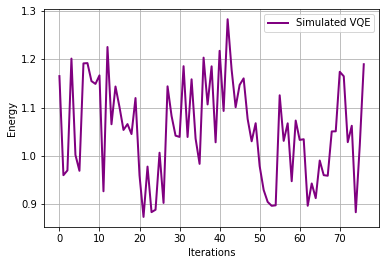

In [65]:
import matplotlib.pyplot as plt
plt.plot(intermediate_info_run[82:], color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=ana_gs, color="tab:red", ls="--", lw=2, label="Target: " + str(ana_gs))
plt.legend()
plt.grid()
plt.show()

In [55]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 77,
    'eigenstate': None,
    'eigenvalue': 1.1898456913653448,
    'optimal_circuit': None,
    'optimal_parameters': array([ 1.45819034,  0.60860944,  0.20149936,  0.49311779,  0.34769581,
        0.2901075 ,  0.50119794, -0.24204399]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}


In [56]:
res_gs = problem.interpret(result).total_energies[0].real
print(problem.interpret(result))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -16.438227185827
  - computed part:      1.189845691365
  - FreezeCoreTransformer extracted energy part: -17.628072877192
~ Nuclear repulsion energy (Hartree): 3.381959618662
> Total ground state energy (Hartree): -13.056267567165
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [15.08001447  0.0  0.0]
 


In [57]:
print(res_gs)
print(ana_gs)
print((ana_gs-res_gs)/ana_gs*100)

-13.05626756716533
-15.59505463113102
16.279436808754333
